# Introduction

For this project phase we will simulate a more realistic approach to the characterization of a small perturbation in an infinite homogeneous media. This is done by solving the following equation:

$$\mathbf{M}=\mathbf{W}\cdot \mathbf{A}$$

where the matrix $\mathbf{M}$ is the measurement (relative contrast), $\mathbf{W}$ is the sensitivity matrix and $\mathbf{A}$ is the perturbation matrix, these matrices and their discretization were derived in the course and their continuous form were used in the phase 1. In the following, we will implement and define the elements of the matrices for a more realistic physical scenario. 

## Physical scenario 

For our model we will retain the physical assumptions of phase 1, meaning:

* Infinite homogeneous media asside from the perturbation with background absorption and scattering coefficients as $\mu_{a}^{0} = 0.1 [cm^{-1}]$ and $\mu_{s}^{\prime} = 10 [cm^{-1}]$ respectively.
* Point-like perturbation with absorption coefficient $\delta \mu_{a} = 0.1 [cm^{-1}]$.
* Source-Detector are in the same position in space.

Nevertheless, for our implementation we will use the following approximations:

* Voxels space: x = [0,64 mm], y = [0,64 mm], z = [0,64 mm], therefore our space is composed of 512 voxels for a step size of 8 in each coordinate.
* Perturbation position: rp = (15,25,10), (15,25,20), (15,25,30) [mm].
* Source-detector pairs space (assumed to be centered in each voxel): x_sd = [4 mm, 60 mm], y_sd = [4 mm, 60 mm].
* Gating time: t = [0,8 ns] with 1ns step.

# Matrix A

The matrix A for our problem represents the perturbation $\delta \mu_{a}(\vec{r})$ from our absporption coefficient $\mu_{a} (\vec{r}) = \mu_{a}^{0}+\delta \mu_{a} (\vec{r})$. The vector $\vec{r}$ represent the distance form the source-detector pairs to the perturbation, initially this vector is composed of three coordinates and consequently can be represented with three indices in cartesian coordinates. Nevertheless, a compressed index notation can be used to simplify our calculations, to compress the indexes we will make the assumption that each voxel corresponds to an element of space meaning that our normal indexes will range from $[0,8 mm]$ in each cartesian component which can be represented graphically as follows:

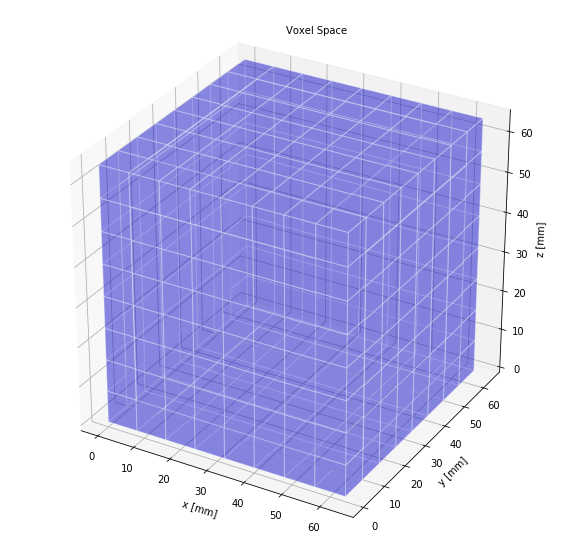

In [2]:
import numpy as np                       #Numpy library python
from numpy import linalg as LA           #Linear algebra functions python
import matplotlib.pyplot as plt          #Plot library functions python
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  #3D plot library functions python
from ipywidgets import interactive       #Dynamic plots library python
import matplotlib.ticker as tick
#------------------------------------------------------------
#Voxels space reconstruction
#------------------------------------------------------------
#plot image size
plt.rcParams['figure.figsize'] = (10,10) 
#create figure
fig = plt.figure()
#specify 3d
ax = fig.gca(projection='3d')
# Make grid
voxels = np.zeros((8, 8, 8)) #size of voxels
# Activate filled Voxels
voxels[0:, 0:, 0:] = True
x,y,z = np.indices((9, 9, 9))*8 
#show voxels grid
ax.voxels(x, y, z, voxels, facecolor = (0.1, 0.1, 0.8, 0.3), edgecolor=(1, 1, 1, 0.3))
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
ax.text2D(0.5, 0.95, "Voxel Space", transform=ax.transAxes)

plt.show()

As we can see our space is divided by voxels of dimension $8\times8\times8$ which correspond to an element, the index of each element can be referred as follows (assuming that the number of elements in $x,y$ and $z$ are the same):

$$m^{\prime} = m + N_{m}(n + l \cdot N_{m})$$

Here $m^{\prime}$ refers to the index of the voxel (counting them as a sequence, like a chess board) with a range of values between $[0,511]$, $m$ represents the elements in $y$ (voxel representing $y$, rows) with a range of values between $[0,7]$, $n$ represents the elements in $x$ (voxels representing $x$, columns) with a range of values between $[0,7]$, $l$ represents the elements in $z$ (voxels representing $z$,levels) with a range of values between $[0,7]$ and $N_{m}$ represents the total number of elements that can be represented by the index $m$ (a total of $8$ elements). As an example we show the elements $m^{\prime} = 56$ and $m^{\prime} = 511$ which corresponds to the coordinates $(m,n,l) = (0,7,0)$ and $(m,n,l) = (7,7,7)$ respectively.

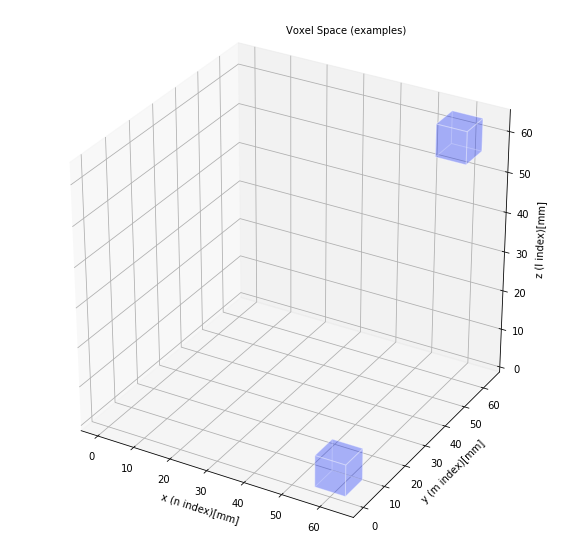

In [3]:
#----------------------------------------------------
#Index compression example
#----------------------------------------------------
#plot image size
plt.rcParams['figure.figsize'] = (10,10) 
#create figure
fig = plt.figure()
#specify 3d
ax = fig.gca(projection='3d')
# Make grid
voxels = np.zeros((8, 8, 8)) #size of voxels
# Activate filled Voxels
voxels[7, 0, 0] = True # coordinates as (x,y,z) = (n,m,l)
voxels[7, 7, 7] = True
x,y,z = np.indices((9,9,9))*8 
#show voxels grid
ax.voxels(x, y, z, voxels, facecolor = (0.1, 0.2, 1, 0.2), edgecolor=(1, 1, 1, 0.3))
ax.set_xlabel('x (n index)[mm]')
ax.set_ylabel('y (m index)[mm]')
ax.set_zlabel('z (l index)[mm]')
ax.text2D(0.5, 0.95, "Voxel Space (examples)", transform=ax.transAxes)
plt.show()

Then, by using index compression our matrix A can be represented through all space using one index, leaving a $512\times1$ matrix. Then for our perturbation with coordinates (15,25,10), (15,25,20), (15,25,30) would translate to the discrete space of voxels elements (2,3,2), (2,3,3), (2,3,4) meaning that the voxels numbers are $(n,m,l) = (1,2,1),(1,2,2),(1,2,3)$ ($N_{m} = 8$) that represent the elements $m^{\prime} = 81,145,209$. So our matrix A will refer to the following elements as the perturpation point (blue voxels):

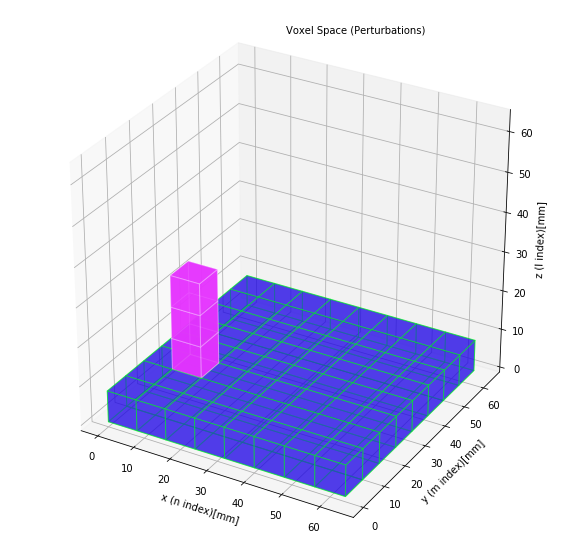

In [4]:
#----------------------------------------------------------------------------------
#3D representation of absorption perturbation position (A with compressed indices)
#----------------------------------------------------------------------------------
#plot image size
plt.rcParams['figure.figsize'] = (10,10) 
#create figure
fig = plt.figure()
#specify 3d
ax = fig.gca(projection='3d')
# Make grid
voxels = np.zeros((8, 8, 8)) #size of voxels
voxelsemp = np.zeros((8, 8, 8))
# Activate filled Voxels
voxels[1, 2, 1] = True # coordinates as (x,y,z) = (n,m,l)
voxels[1, 2, 2] = True
voxels[1, 2, 3] = True
voxelsemp[0:,0:,0] = True
x,y,z = np.indices((9,9,9))*8 
#show voxels grid
ax.voxels(x, y, z, voxels, facecolor = (0.9, 0.2, 1, 0.8), edgecolor=(1, 1, 1, 0.3))
ax.voxels(x, y, z, voxelsemp, facecolor = (0.1, 0, 0.9, 0.5), edgecolor=(0, 1, 0.1, 0.5))
ax.set_xlabel('x (n index)[mm]')
ax.set_ylabel('y (m index)[mm]')
ax.set_zlabel('z (l index)[mm]')
ax.text2D(0.5, 0.95, "Voxel Space (Perturbations)", transform=ax.transAxes)
plt.show()

## Recap

Our Matrix A is composed then by the following:

* A matrix of size $(512\times 1)$.
* Units of the absorption perturbation $\delta \mu_{a}$ that are $[cm^{-1}]$

# Matrix M construction

We proceed with the contruction of the M matrix, first we define all the parameters that we will use throughout the next sections.

In [5]:
#--------------------------------------------------------------
#General parameters definition
#--------------------------------------------------------------
voxel_step = 8                      #Division of space in voxels
Nvox_dim = int(64/voxel_step)       #Number of voxels per axis
Nvox = Nvox_dim**3                  #Number of Voxels representing the space
dmu_a = 0.1                         #Absorption perturbation [cm^-1]
t = np.linspace(0.03, 8, 9)*10**-9  # Time [s]
ma_0 = 0.1                          # Absorption coeff. [cm^-1]
ms_p = 10                           # Scattering coeff. [cm^-1]
D = 1/(3*ms_p)                      # Diffusion coeff.
c = 3*10**10
pert_indxs = [2+Nvox_dim*2+Nvox_dim**2,2+Nvox_dim*3+2*Nvox_dim**2,2+Nvox_dim*2+3*Nvox_dim**2] # Voxels index for perturbation position

In [6]:
#--------------------------------------------------------
# Matrix A construction
#--------------------------------------------------------
#Function that constructs the A matrix
def matrixA (Nvox,dmu_a,pert_indx):
    A = np.zeros(Nvox) 
    A[pert_indx] = dmu_a
    return A
Atest = matrixA(Nvox,dmu_a,pert_indxs[1])


## M matrix

For this matrix we use our past results defining the M matrix as the measurement matrix where its elements correspond to the fluence detected by each Detector in our discretization of 64 voxels on the surface. This detection is also dependent on the specified time gate used since the frequency of detection is limited, therefore for each 64 detectors we will have 1 detection time, since our time window is of 8 ns we will have 9 time gates with 1ns step, leading then to 576 detection measurements. 

In [7]:
#-------------------------------------------------------
# Matrix M construction
#-------------------------------------------------------
# Function for M construction
def matrixM (t,Nvox_dim,D,dma,pert_pos):
    SD_pairs = int(Nvox_dim*Nvox_dim)         # Number of S-D pairs
    m_indx = int(SD_pairs*len(t))             # Index of time gates counted for the S-D pairs
    rvox = np.zeros(SD_pairs)                 # Vector compressed for position from S-D pair to perturbation (64x1)
    M = np.zeros(m_indx)                      # Matrix of measurements with compressed indexes (576x1)
    xvoxs = 1.5-np.linspace(.4,6.0,Nvox_dim)# Coord. in x for the vector from S-D pairs to the perturbation
    yvoxs = 2.5-np.linspace(.4,6.0,Nvox_dim)# Coord. in y for the vector from S-D pairs to the perturbation
    zvoxs = [6.4-1.2,6.4-2.0,6.4-2.8]       # Coord. in z for the vector from S-D pairs to the perturbation
    # This cycles calculate the distance between source-detector pairs and perturbation
    for i in range(len(xvoxs)):
        for j in range(len(yvoxs)):
            i_p = i +j*Nvox_dim            # Index compression
            rvox[i_p] = np.sqrt(xvoxs[i]**2+yvoxs[j]**2+zvoxs[pert_pos]**2) 
    # Calculation of M through the relative contrast
    for k in range(len(t)):
        for l in range(len(rvox)):
            kcount = l + k*len(rvox)
            c = 3*10**10
            M[kcount] = 1/(4*np.pi*D)*dma*(2/rvox[l])*np.exp(-rvox[l]**2/(c*D*t[k]))
    return M

#-----------------------------------------------------------
#Contour plots construction function for M matrix
def plotting(gate,pert_pos,i,k):
    M_cont = np.zeros((Nvox_dim,Nvox_dim))    # Matrix for contour plot 
    M = matrixM (t,Nvox_dim,D,dmu_a,pert_pos) # Construction of M matrix
    #Reordering of the data of M matrix
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        M_cont[:Nvox_dim,j] = M[counter:counter+Nvox_dim]
        counter = counter + Nvox_dim
        j = j+1
    return maxs[i,k].contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),np.transpose(M_cont))
    # On jupyter notebooks these commands are used for an interactive plot
    #plt.contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),np.transpose(M_cont))
    #plt.colorbar()

#Commands to call the interative plots, only works on jupyter notebooks
#intermap = interactive(plotting,gate = (Nvox_dim*Nvox_dim,Nvox_dim*Nvox_dim*len(t),Nvox_dim*Nvox_dim),pert_pos = (0,2,1))
#intermap


### Example of M matrix for one perturbation position

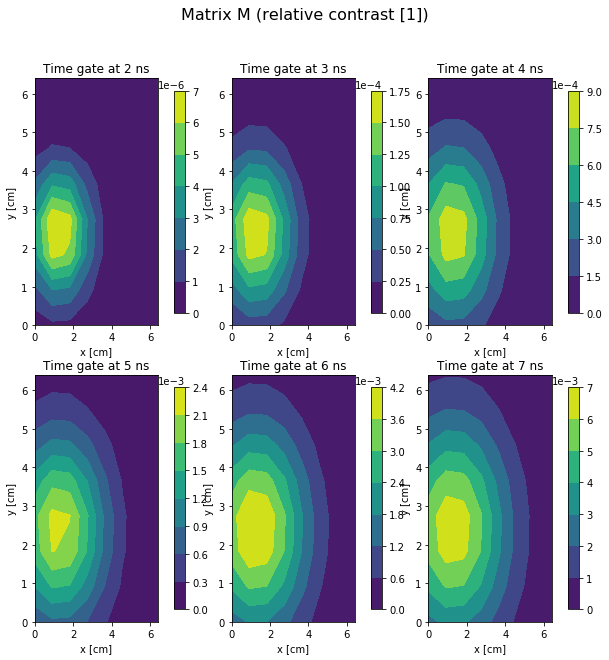

In [23]:
fig, maxs = plt.subplots(2,3) #Creation of a plot with a matrix of 2x3 subplots
fig.suptitle('Matrix M (relative contrast [1])', fontsize=16)  # Title format
count = 192 # starting gate (2ns)
ns = 1 #variable for printing format
for i in range(2):
    for j in range(3):
        ns = ns+1
        im = plotting(count,1,i,j) #calculation of the data for the subplots
        #Subplots formatting
        maxs[i,j].set_title('Time gate at %.0f ns' % ns)
        maxs[i,j].set_xlabel('x [cm]')
        maxs[i,j].set_ylabel('y [cm]')
        cb = fig.colorbar(im,ax = maxs[i,j],shrink=0.9, pad = 0.1)
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()
        count = count+64 #gate increase
count = 0 #gate variable restart

## Recap

Our Matrix M is composed then by the following:

* A matrix of size $(576\times 1)$.
* Since we are representing the Measurement as the relative contrast, the values of this matrix are adimensionless, nevertheless we are taking each time 64 measurements for every source detector pair therefore we have $64*9$ elements that represent the relative contrast for each time gate of 1 ns. 

# Matrix W construction

For the matrix W we measure the sensitivity of our voxel space to each source detector pair and at each time gate. This matrix is build up by calculating the distance between each S-D pair and each voxel at different time gates, therefore our matrix will be composed by 576 elements (64 source detector pairs per each time gate) times 512 elements (voxels seen per each detector). 

In [9]:
#------------------------------------------------------------
# Matrix W construction (576x512)
#------------------------------------------------------------
def matrixW(t,Nvox_dim,D,c):
    SD_pairs = int(Nvox_dim*Nvox_dim)         # Number of S-D pairs
    m_indx = int(SD_pairs*len(t))             # Index of time gates counted for the S-D pairs
    rvox = np.zeros((SD_pairs,Nvox))          # Vector compressed for position from S-D pair to perturbation
    W = np.zeros((m_indx,Nvox))               # Sensitivity Matrix with compressed indexes (576x512)
    x_SD = np.linspace(.4,6.0,Nvox_dim)       # Coord. in x for the vector from S-D pairs 
    y_SD = np.linspace(.4,6.0,Nvox_dim)       # Coord. in y for the vector from S-D pairs 
    z_SD = 6.4
    xvox = np.linspace(.4,6.0,Nvox_dim)       # Voxels range in x direction
    yvox = np.linspace(.4,6.0,Nvox_dim)
    zvox = np.linspace(.4,6.0,Nvox_dim)

    # Index compression for the distance between the S-D pairs to the perturbation
    for j in range(len(y_SD)):
        for i in range(len(x_SD)):
            for l in range(len(zvox)):
                for n in range(len(xvox)):
                    for m in range(len(yvox)):
                        n_p = i + j*Nvox_dim
                        m_p = m + Nvox_dim*(n + l*Nvox_dim)            # Index compression for voxels
                        rvox[n_p,m_p] = np.sqrt((x_SD[i]-xvox[n])**2+(y_SD[j]-yvox[m])**2+(z_SD-zvox[l])**2) 
    # Creation of the W matrix
    i_c = 0
    for k in range(len(t)):
        for i in range(SD_pairs):
            for j in range(Nvox):
                W[i_c,j] = 1/(4*np.pi*D)*(2/rvox[i,j])*np.exp(-rvox[i,j]**2/(c*D*t[k]))
            i_c = i_c+1
    return W

## W matrix composition

First we show a 2D representation of W by making a contour plot of each element of the 2D matrix. In this representation we are able to observe the influence of the time gate in our sensitivity, as expected at later time gates we will have more sensitivity in our detectors since we integrate over a bigger amount of time. Another point we can see with this representation is that also as expected the top voxels (where our S-D pairs are have more sensitiviy) decay on sensitivity as they go down the "tissue" having a maximum depth of approximate 3 voxels at later time gates.

Second, we plot the W matrix 2nd dimension (voxels per each source detector pair) to check our last point, and we are able to see that is true, at higher number of indices, more close to the S-D pairs therefore more sensistivity. In particular we showed the detector with voxel index 448 that is in the window of 7ns gate.  

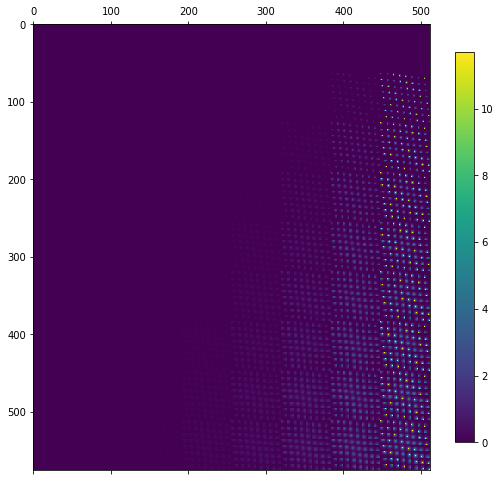

In [10]:
W =  matrixW(t,Nvox_dim,D,c)
# Matrix compositon by a 2D representation
plt.matshow(W)
plt.colorbar(shrink = 0.7)
plt.show()

Text(0.5, 1.0, 'Sensitivity Matrix 2D representation')

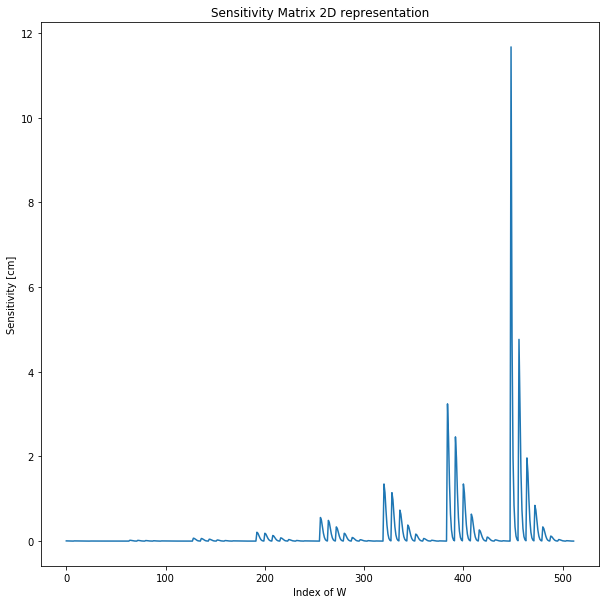

In [24]:
plt.plot(np.arange(0,512,1),W[448,:])
#Labels
plt.xlabel('Index of W')
plt.ylabel('Sensitivity [cm]')
plt.title('Sensitivity Matrix 2D representation')

## M construction via W matrix

To show that our W matrix is correctly constructed, we calculate M via our linear problem. First we show a function that constructs a contour plot of the values of the relative contrast for a perturbation position at different time gate, later we show the same but in a static form. 

In [12]:
#--------------------------------------------------------
#Contour plots construction function
def plotting2(gate,i,k):
    W =  matrixW(t,Nvox_dim,D,c)
    M_cont = np.zeros((Nvox_dim,Nvox_dim))    # Matrix for contour plot (8x8x8)
    Mtest = np.matmul(W,Atest)
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        M_cont[:Nvox_dim,j] = Mtest[counter:counter+Nvox_dim]
        counter = counter + Nvox_dim
        j = j+1
    return waxs[i,k].contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),M_cont)
    #plt.colorbar()
    
# Commands for the interactive plot using only jupyter notebooks
# intermap2 = interactive(plotting2,gate = (Nvox_dim*Nvox_dim,Nvox_dim*Nvox_dim*len(t),Nvox_dim*Nvox_dim))
# intermap2

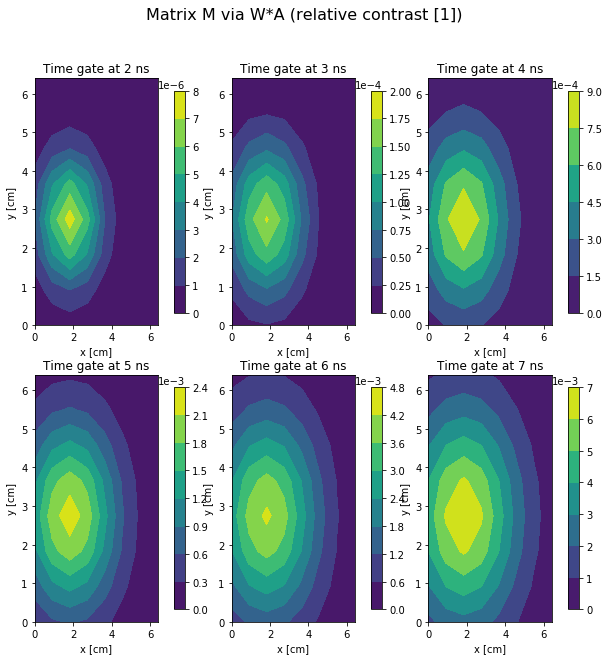

In [22]:
#---------------------------------------------------------------------------------------
fig, waxs = plt.subplots(2,3) #Creation of a plot with a matrix of 2x3 subplots
# fig.subplots_adjust(wspace=0.5)
fig.suptitle('Matrix M via W*A (relative contrast [1])', fontsize=16)  # Title format
count = 192 # starting gate (2ns)
ns = 1 #variable for printing format
for i in range(2):
    for j in range(3):
        ns = ns+1
        im = plotting2(count,i,j) #calculation of the data for the subplots
        #Subplots formatting
        waxs[i,j].set_title('Time gate at %.0f ns' % ns)
        waxs[i,j].set_xlabel('x [cm]')
        waxs[i,j].set_ylabel('y [cm]')
        cb = fig.colorbar(im,ax = waxs[i,j],shrink=0.9, pad = 0.1)
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()
        count = count+64 #gate increase
count = 0 #gate variable restart

## Recap

Our Matrix W is composed then by the following:

* A matrix of size $(576\times 512)$.
* The units of this matrix are $[cm]$ since they represent our voxels space seen by the detectors and because it needs to have opposite dimensions of our matrix A in order to achieve a relative contrast measurement. 